In [1]:
# import libraries
import pandas as pd
import numpy as np

# load SBA data
sba = pd.read_csv('/work/SBAcase.11.13.17.csv', low_memory=False)

# preview
print(sba.shape)
print(sba.columns)

# keep important columns
cols_to_use = [
    'DisbursementGross',  # loan amount
    'Term',               # loan term
    'NoEmp',              # number of employees
    'NewExist',           # new or existing business
    'UrbanRural',         # location type
    'State',              # US State
    'MIS_Status'          # loan status (paid in full or charged off)
]
df = sba[cols_to_use]

# drop missing targets
df = df.dropna(subset=['MIS_Status'])

# create binary target: 1 = Default (charged off), 0 = Paid in full
df['target'] = df['MIS_Status'].apply(lambda x: 1 if x.strip() == 'CHGOFF' else 0)

# drop missing feature values
df = df.dropna(subset=['DisbursementGross', 'Term', 'NoEmp'])

# check after cleaning
print(df['target'].value_counts())
print(df.head())

(2102, 35)
Index(['Selected', 'LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank',
       'BankState', 'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'ChgOffDate', 'DisbursementDate',
       'DisbursementGross', 'BalanceGross', 'MIS_Status', 'ChgOffPrinGr',
       'GrAppv', 'SBA_Appv', 'New', 'RealEstate', 'Portion', 'Recession',
       'daysterm', 'xx', 'Default'],
      dtype='object')
target
0    1416
1     686
Name: count, dtype: int64
   DisbursementGross  Term  NoEmp  NewExist  UrbanRural State MIS_Status  \
0              32812    36      1       1.0           0    CA      P I F   
1              30000    56      1       1.0           0    CA      P I F   
2              30000    36     10       1.0           0    CA      P I F   
3              50000    36      6       1.0           0    CA      P I F   
4             343000   240     65       1.0           1

In [2]:
from sklearn.preprocessing import LabelEncoder

# initialize label encoder
le = LabelEncoder()

# encode categorical columns
for col in ['State', 'UrbanRural', 'NewExist']:
    df[col] = le.fit_transform(df[col].astype(str))

# check the DataFrame after encoding
print(df.head())


   DisbursementGross  Term  NoEmp  NewExist  UrbanRural  State MIS_Status  \
0              32812    36      1         1           0      0      P I F   
1              30000    56      1         1           0      0      P I F   
2              30000    36     10         1           0      0      P I F   
3              50000    36      6         1           0      0      P I F   
4             343000   240     65         1           1      0      P I F   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Define your features (X) and target (y)
features = ['DisbursementGross', 'Term', 'NoEmp', 'NewExist', 'UrbanRural', 'State']
X = df[features]
y = df['target']

# Step 2: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Step 4: Predictions
y_pred = logreg.predict(X_test)

# Step 5: Evaluate
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score (Logistic Regression):", roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       273
           1       1.00      0.01      0.03       148

    accuracy                           0.65       421
   macro avg       0.83      0.51      0.41       421
weighted avg       0.77      0.65      0.52       421

ROC-AUC Score (Logistic Regression): 0.8705573705573706


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score # I just put for Cross Validation

# Features and target
features = ['DisbursementGross', 'Term', 'NoEmp', 'NewExist', 'UrbanRural', 'State']
X = df[features]
y = df['target']

# Train/test split (redefining to ensure variables are initialized)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=10, random_state=42)

# Step 2: Train Random Forest
rf.fit(X_train, y_train)

# Step 3: Predict
y_pred_rf = rf.predict(X_test)

# Step 4: Evaluate
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("ROC-AUC Score (Random Forest):", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# Step 5: Cross Validation for check our model is not overfit
scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print("CV ROC-AUC mean:", scores.mean())

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       273
           1       0.83      0.84      0.84       148

    accuracy                           0.88       421
   macro avg       0.87      0.87      0.87       421
weighted avg       0.88      0.88      0.88       421

ROC-AUC Score (Random Forest): 0.9432481932481933
CV ROC-AUC mean: 0.9513567517728273


/tmp/ipykernel_79/996778807.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


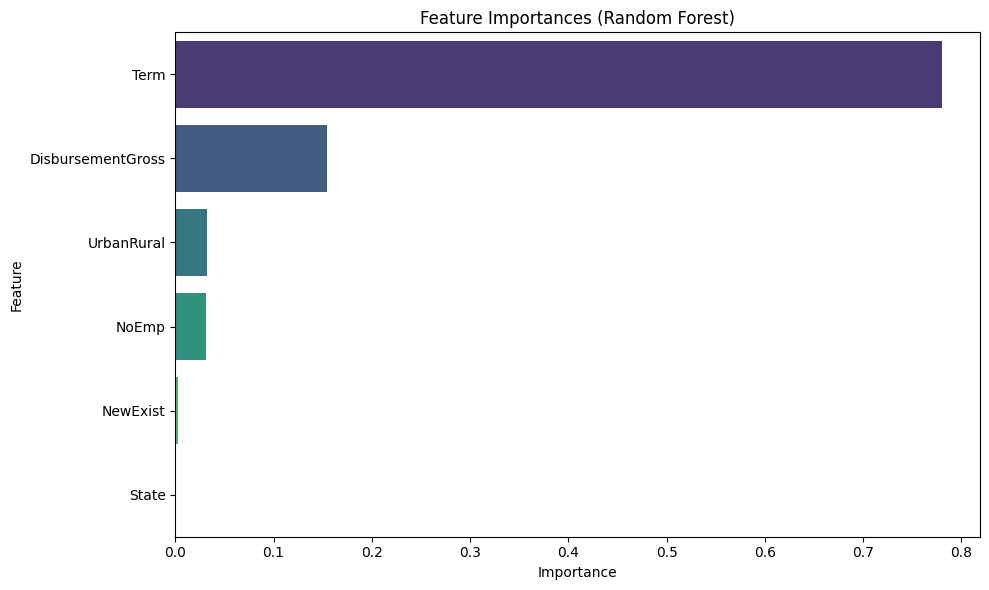

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [6]:
!pip install xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 2.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install xgboost==3.0.0


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [17]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

print("ROC-AUC Score (XGBoost):", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))

# Cross validation
scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='roc_auc')
print("XGBoost CV ROC-AUC mean:", scores_xgb.mean())

/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:08:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:08:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:08:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:08:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:08:35] WARNING: /w

/tmp/ipykernel_79/1161772265.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TermCategory', y='Defaulted', data=term_category_default, palette='coolwarm')


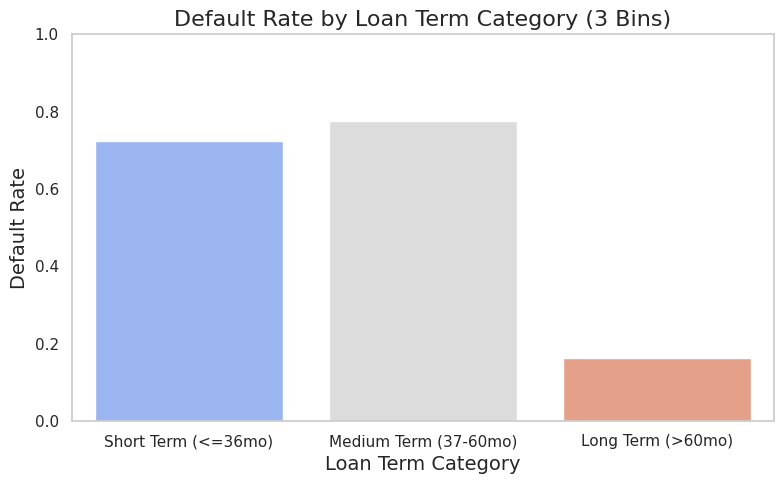

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# create a new 'Term Category' feature with 3 bins
df['TermCategory'] = df['Term'].apply(
    lambda x: 'Short Term (<=36mo)' if x <= 36 else 
              'Medium Term (37-60mo)' if x <= 60 else 
              'Long Term (>60mo)'
)

# calculate average default rate by Term Category
term_category_default = df.groupby('TermCategory')['Defaulted'].mean().reset_index()

# sort the categories for better visual consistency
term_category_default['TermCategory'] = pd.Categorical(
    term_category_default['TermCategory'],
    categories=['Short Term (<=36mo)', 'Medium Term (37-60mo)', 'Long Term (>60mo)'],
    ordered=True
)

# plot
plt.figure(figsize=(8, 5))
sns.barplot(x='TermCategory', y='Defaulted', data=term_category_default, palette='coolwarm')

plt.title('Default Rate by Loan Term Category (3 Bins)', fontsize=16)
plt.xlabel('Loan Term Category', fontsize=14)
plt.ylabel('Default Rate', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

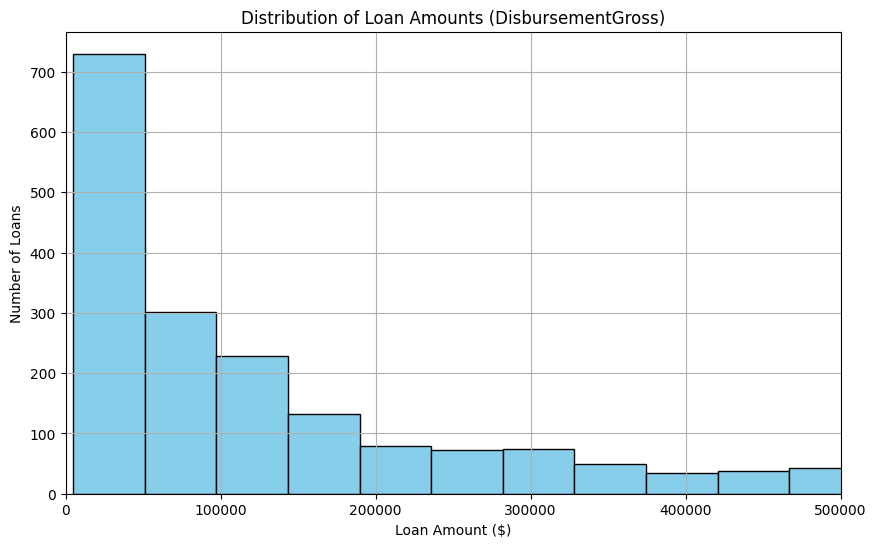

In [10]:
import matplotlib.pyplot as plt

# Histogram of loan amounts
plt.figure(figsize=(10,6))
plt.hist(df['DisbursementGross'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Loan Amounts (DisbursementGross)')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Number of Loans')
plt.xlim(0, 500000)  # Optional: focus on loans < $500k
plt.grid(True)
plt.show()


/tmp/ipykernel_79/3057402298.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="LoanSizeCategory", y="Default", estimator=np.mean, palette="Blues_d")


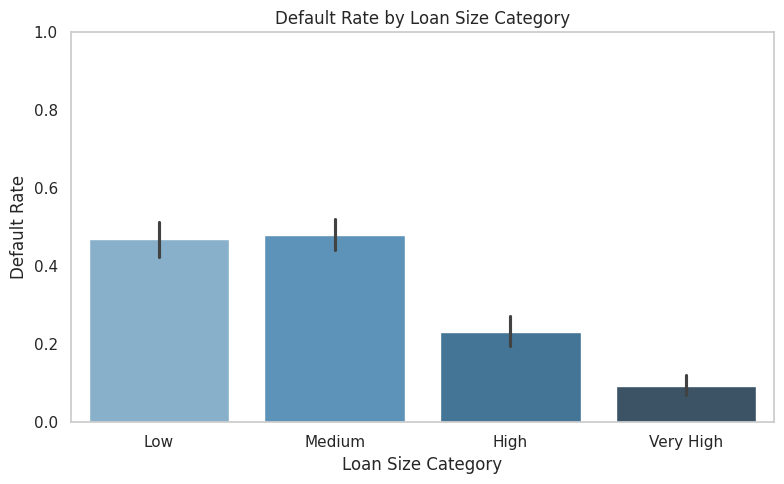

/tmp/ipykernel_79/3057402298.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emp_bins.astype(str), y=df['Default'], estimator=np.mean, palette="Greens_d")


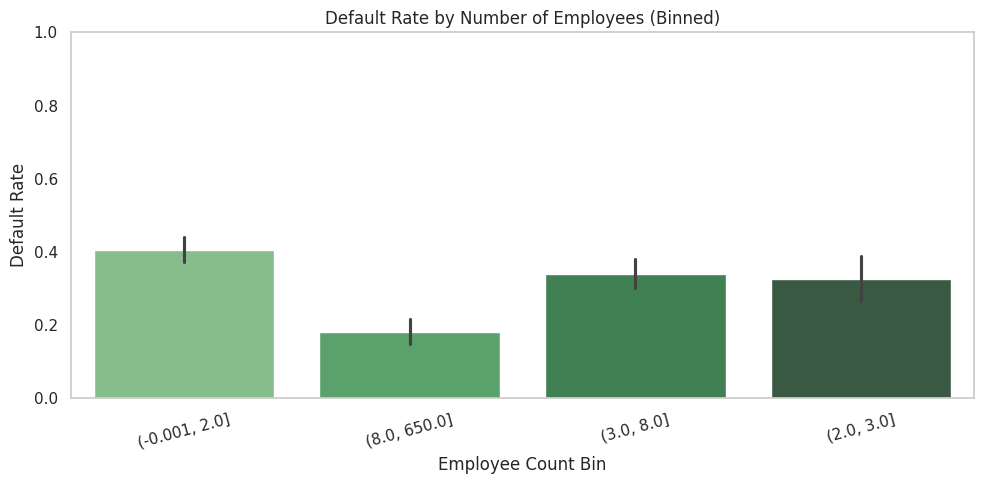

In [11]:
# Additional visualizations for SBA Loan Default Analysis

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

df['Default'] = df['MIS_Status'].apply(lambda x: 1 if str(x).strip().upper() == 'CHGOFF' else 0)
df['LoanSizeCategory'] = pd.qcut(df['DisbursementGross'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
df['TermCategory'] = df['Term'].apply(lambda x: 'Short (<=36mo)' if x <= 36 else 'Medium (37-60mo)' if x <= 60 else 'Long (>60mo)')

# Plot 1: Default rate by Loan Size Category
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="LoanSizeCategory", y="Default", estimator=np.mean, palette="Blues_d")
plt.title("Default Rate by Loan Size Category")
plt.xlabel("Loan Size Category")
plt.ylabel("Default Rate")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# Plot 3: Default rate by Number of Employees (Binned)
plt.figure(figsize=(10, 5))
emp_bins = pd.qcut(df['NoEmp'], q=4)
sns.barplot(x=emp_bins.astype(str), y=df['Default'], estimator=np.mean, palette="Greens_d")
plt.title("Default Rate by Number of Employees (Binned)")
plt.xlabel("Employee Count Bin")
plt.ylabel("Default Rate")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cd197272-535e-4214-be2d-63a4e428eb11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>